# 04. SO SÁNH WINDOW SIZE (30 – 60 – 90)

Chọn model tốt nhất

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = np.load("D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\scaler.npy", allow_pickle=True).item()
X_test = np.load("D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\X_test.npy")
y_test = np.load("D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\y_test.npy")
X_test_t = torch.FloatTensor(X_test).to(device)

In [3]:
# Hàm train nhanh 1 model
def train_lstm(window):
    X_train = np.load(f"D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\X_train.npy")
    y_train = np.load(f"D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\y_train.npy")
    X_val   = np.load(f"D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\X_val.npy")
    y_val   = np.load(f"D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\y_val.npy")

    # Chỉ thay đổi window ở đây
    X_train = X_train[:, -window:, :] if window < 60 else X_train
    X_val   = X_val[:, -window:, :]   if window < 60 else X_val

    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).reshape(-1,1).to(device)
    X_val_t   = torch.FloatTensor(X_val).to(device)
    y_val_t   = torch.FloatTensor(y_val).reshape(-1,1).to(device)

    loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train_t, y_train_t),
        batch_size=32, shuffle=True
    )

    class LSTM(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(1, 50, 2, batch_first=True, dropout=0.2)
            self.fc = nn.Linear(50, 1)
        def forward(self, x):
            out, _ = self.lstm(x)
            return self.fc(out[:, -1, :])

    model = LSTM().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    crit = nn.MSELoss()

    for epoch in range(40):
        model.train()
        for x_b, y_b in loader:
            opt.zero_grad()
            pred = model(x_b)
            loss = crit(pred, y_b)
            loss.backward()
            opt.step()

    model.eval()
    with torch.no_grad():
        pred_scaled = model(X_test_t[:, -window:, :].to(device)).cpu().numpy()
    pred = scaler.inverse_transform(pred_scaled)
    real = scaler.inverse_transform(y_test.reshape(-1,1))

    rmse = np.sqrt(mean_squared_error(real, pred))
    mae  = mean_absolute_error(real, pred)
    mape = np.mean(np.abs((real - pred) / real)) * 100

    return window, rmse, mae, mape, pred


Đang train window = 30...


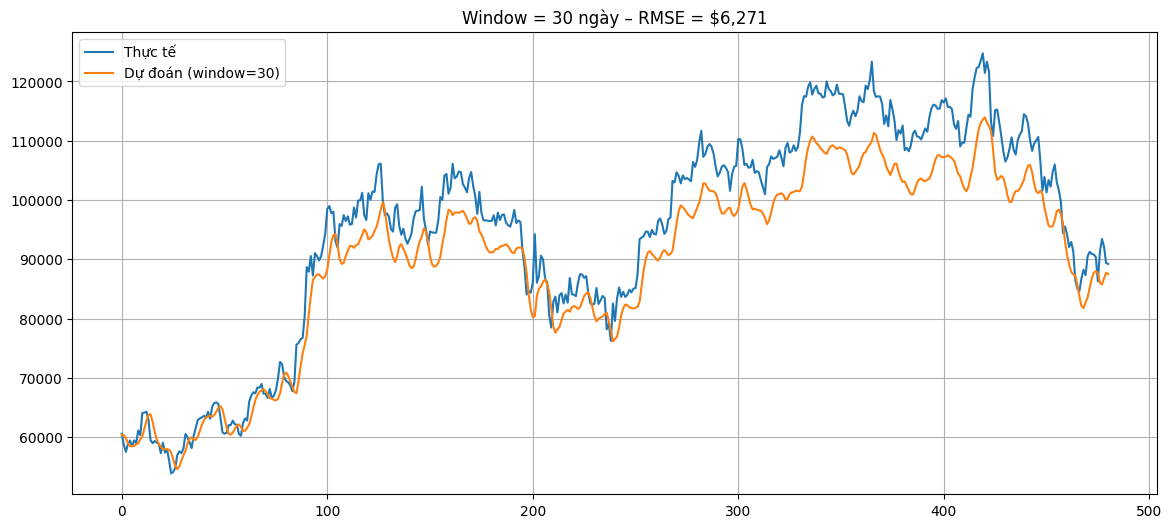


Đang train window = 60...


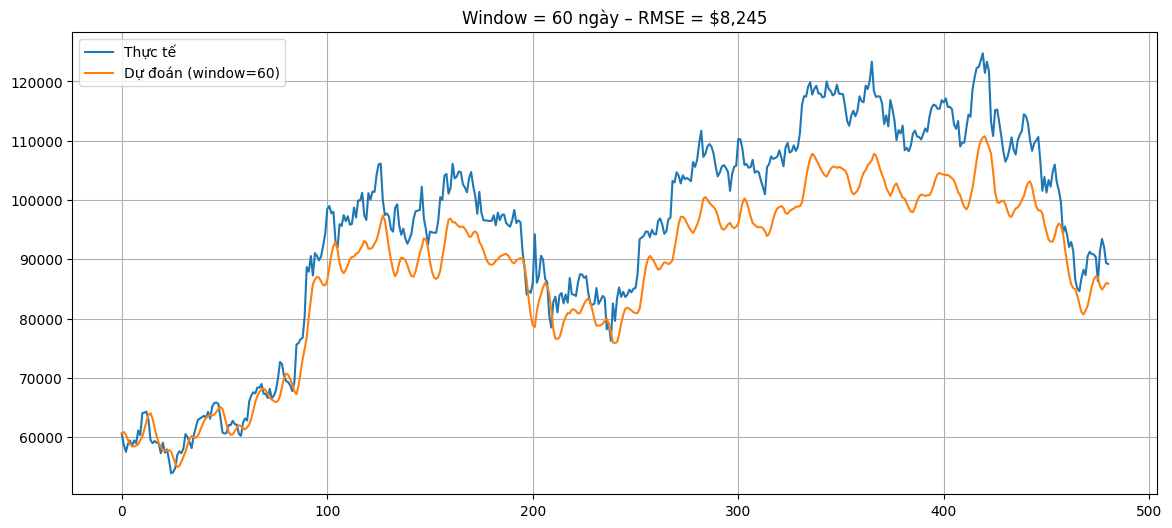


Đang train window = 90...


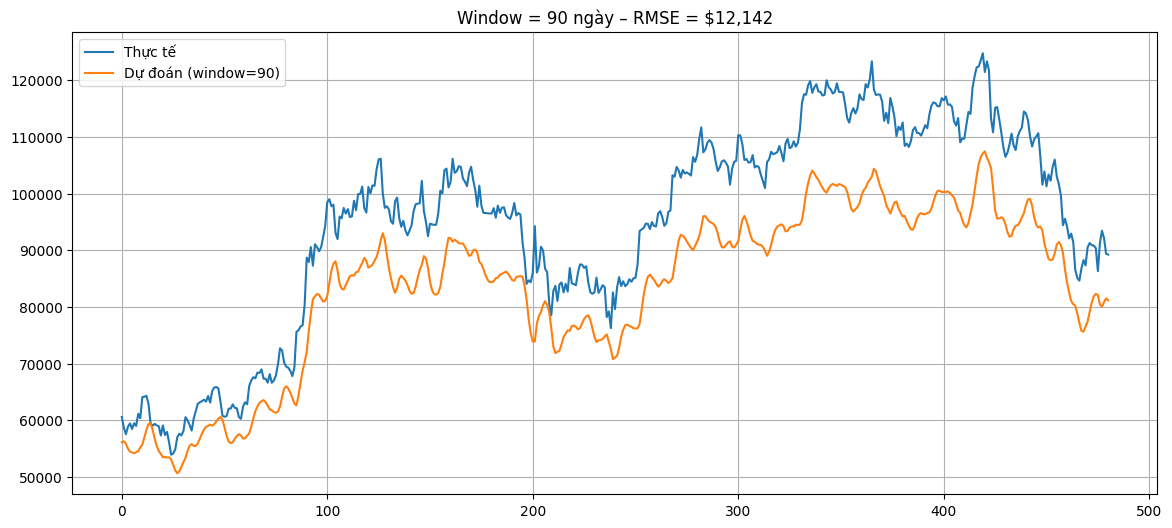

In [4]:
# Chạy 3 window
results = []
for w in [30, 60, 90]:
    print(f"\nĐang train window = {w}...")
    window, rmse, mae, mape, pred = train_lstm(w)
    results.append([window, rmse, mae, mape])
    plt.figure(figsize=(14,6))
    plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='Thực tế')
    plt.plot(pred, label=f'Dự đoán (window={w})')
    plt.title(f'Window = {w} ngày – RMSE = ${rmse:,.0f}')
    plt.legend(); plt.grid(); plt.show()

In [7]:
# Bảng so sánh
import pandas as pd

df_res = pd.DataFrame(results, columns=['Window size', 'RMSE ($)', 'MAE ($)', 'MAPE (%)'])
df_res = df_res.round(2)


df_res = df_res.sort_values('RMSE ($)')  

print("\nBẢNG SO SÁNH WINDOW SIZE")
print(df_res.to_string(index=False))

best_window = df_res.iloc[0]['Window size']
best_rmse = df_res.iloc[0]['RMSE ($)']

print(f"\nMODEL TỐT NHẤT: Window = {int(best_window)} ngày → RMSE = ${best_rmse:,.0f}")


BẢNG SO SÁNH WINDOW SIZE
 Window size  RMSE ($)  MAE ($)  MAPE (%)
          30   6270.74  5345.39      5.30
          60   8244.60  7066.92      6.95
          90  12142.22 11284.20     11.50

MODEL TỐT NHẤT: Window = 30 ngày → RMSE = $6,271


In [9]:
# Lưu bảng + ảnh
import os

os.makedirs("results", exist_ok=True)

df_res.to_csv("results/window_comparison.csv", index=False)
df_res.iloc[0:1].to_csv("results/BEST_MODEL.csv", index=False)

print("ĐÃ LƯU THÀNH CÔNG BẢNG VÀO:")
print("   → results/window_comparison.csv")
print("   → results/BEST_MODEL.csv")

ĐÃ LƯU THÀNH CÔNG BẢNG VÀO:
   → results/window_comparison.csv
   → results/BEST_MODEL.csv


In [10]:
# Commit
print("\nHOÀN THÀNH TUẦN 2 – NGÀY 3!")
print("Bạn đã có:")
print("• 3 model với 3 window size")
print("• Bảng so sánh + model tốt nhất")
print("• Đủ kết quả để nộp tuần này cho GVHD")
print("• Sẵn sàng viết Chương 4 báo cáo!")


HOÀN THÀNH TUẦN 2 – NGÀY 3!
Bạn đã có:
• 3 model với 3 window size
• Bảng so sánh + model tốt nhất
• Đủ kết quả để nộp tuần này cho GVHD
• Sẵn sàng viết Chương 4 báo cáo!
